# Introduction

- **Dataset**: The data consists of some scientific articles that includes **title** and its **abstract**. The objective is to predict which category the article is in based on these two unstructured texts. There are six categories, and each article can belong to more than one category.
- **Modeling**: We use SciBERT, a variant of BERT model, to obtain embedding for the title and abstract. We use **huggingface** library for the BERT model. We concateate the embedding and feed to MLP layer to predict 1/0 for each subject **independently**.
- **Result**: Obtain substantial results on accuracy and F1 score metrics.

In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from transformers import AutoTokenizer, TFAutoModel

%matplotlib inline

# Load Dataset

In [3]:
import pandas as pd 
train=pd.read_csv('/kaggle/input/dataquest-challenge-2/train.csv')
test=pd.read_csv('/kaggle/input/dataquest-challenge-2/test.csv')


In [4]:
train.head()

,ABSTRACT,category
0,a backpressure algorithm has been widely used ...,", Computer Science, Mathematics, Optimization ..."
1,"inside this paper, we present an exactly solva...",", Physics, Strongly Correlated Electrons"
2,a present numerical study aims at shedding lig...,", Physics, Fluid Dynamics"
3,with the help of angle-resolved photoemission ...,", Physics, Strongly Correlated Electrons, Supe..."
4,based on sub-arcsecond atacama large millimete...,", Physics, Astrophysics of Galaxies"


In [5]:
# Split the categories and create new columns
categories = train['category'].str.get_dummies(sep=',')
train = pd.concat([train, categories], axis=1)

# Rename the columns to remove special characters
train.columns = train.columns.str.replace('[^a-zA-Z0-9]', '')

# Drop the original Category column
train = train.drop('category', axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [6]:
train.head()

,ABSTRACT,AnalysisofPDEs,Applications,ArtificialIntelligence,AstrophysicsofGalaxies,ComputationandLanguage,ComputerScience,ComputerVisionandPatternRecognition,CosmologyandNongalacticAstrophysics,DataStructuresandAlgorithms,...,OptimizationandControl,Physics,RepresentationTheory,Robotics,SocialandInformationNetworks,Statistics,StatisticsTheory,StronglyCorrelatedElectrons,Superconductivity,SystemsandControl
0,a backpressure algorithm has been widely used ...,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,"inside this paper, we present an exactly solva...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,a present numerical study aims at shedding lig...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,with the help of angle-resolved photoemission ...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,based on sub-arcsecond atacama large millimete...,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
ss = pd.read_csv('/kaggle/input/dataquest-challenge-2/SampleSubmission.csv')
train.shape, ss.shape , test.shape

((10000, 30), (4004, 30), (4004, 1))

In [8]:
train.columns = train.columns.str.replace(' ', '')


In [9]:
article_labels = train[['AnalysisofPDEs', 'Applications', 'ArtificialIntelligence',
       'AstrophysicsofGalaxies', 'ComputationandLanguage', 'ComputerScience',
       'ComputerVisionandPatternRecognition',
       'CosmologyandNongalacticAstrophysics', 'DataStructuresandAlgorithms',
       'DifferentialGeometry', 'EarthandPlanetaryAstrophysics',
       'FluidDynamics', 'InformationTheory',
       'InstrumentationandMethodsforAstrophysics', 'MachineLearning',
       'MaterialsScience', 'Mathematics', 'Methodology', 'NumberTheory',
       'OptimizationandControl', 'Physics', 'RepresentationTheory', 'Robotics',
       'SocialandInformationNetworks', 'Statistics', 'StatisticsTheory',
       'StronglyCorrelatedElectrons', 'Superconductivity',
       'SystemsandControl']]
article_labels.head()

,AnalysisofPDEs,Applications,ArtificialIntelligence,AstrophysicsofGalaxies,ComputationandLanguage,ComputerScience,ComputerVisionandPatternRecognition,CosmologyandNongalacticAstrophysics,DataStructuresandAlgorithms,DifferentialGeometry,...,OptimizationandControl,Physics,RepresentationTheory,Robotics,SocialandInformationNetworks,Statistics,StatisticsTheory,StronglyCorrelatedElectrons,Superconductivity,SystemsandControl
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


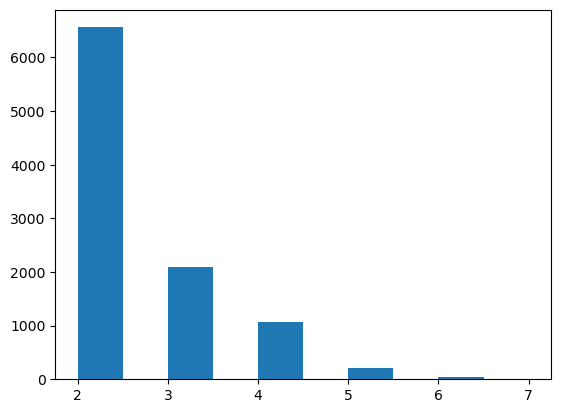

In [10]:
subject_df = train.drop(['ABSTRACT'], axis=1)

subject_per_entry = subject_df.sum(axis=1)
subject_per_entry.hist(grid=False)
plt.show()

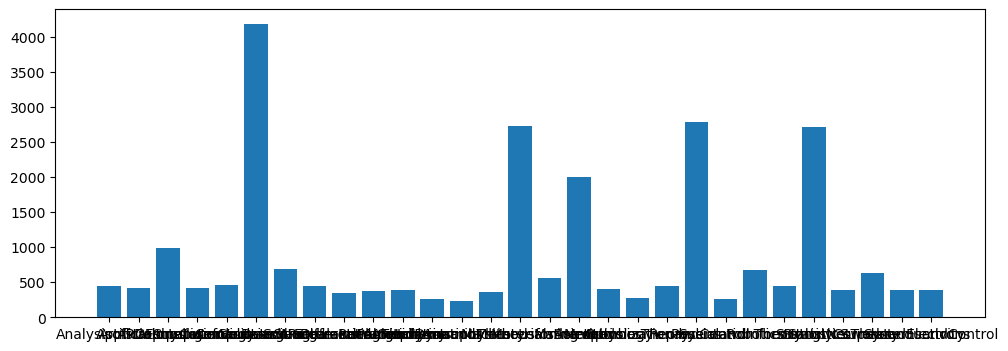

In [11]:
column_names = subject_df.columns
X_axis = range(len(column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, subject_df.sum())
plt.xticks(X_axis, column_names)

plt.show()

In [12]:
train.head()

,ABSTRACT,AnalysisofPDEs,Applications,ArtificialIntelligence,AstrophysicsofGalaxies,ComputationandLanguage,ComputerScience,ComputerVisionandPatternRecognition,CosmologyandNongalacticAstrophysics,DataStructuresandAlgorithms,...,OptimizationandControl,Physics,RepresentationTheory,Robotics,SocialandInformationNetworks,Statistics,StatisticsTheory,StronglyCorrelatedElectrons,Superconductivity,SystemsandControl
0,a backpressure algorithm has been widely used ...,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,"inside this paper, we present an exactly solva...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,a present numerical study aims at shedding lig...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,with the help of angle-resolved photoemission ...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,based on sub-arcsecond atacama large millimete...,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [14]:
abstract_lens = [ len(tokenizer.tokenize(x)) for x in train['ABSTRACT'] ]

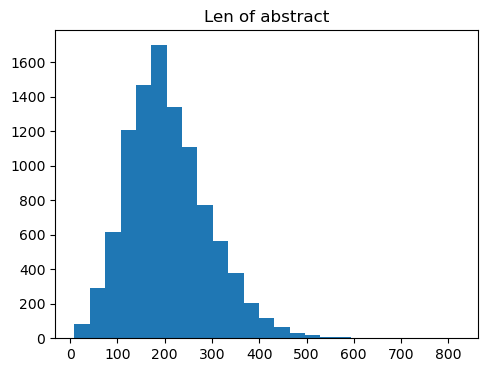

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.hist(abstract_lens, bins=25)
plt.title('Len of abstract')

plt.show()

# Preprocess Dataset

In [16]:
def tokenize(x: tf.Tensor, max_length=20):
    x = x.numpy().decode('utf-8')
    tokens = tokenizer.encode_plus(x, 
                                   padding='max_length', 
                                   return_tensors="tf", 
                                   max_length=max_length, 
                                   truncation=True,  
                                   pad_to_max_length=True, 
                                   return_token_type_ids=False)
    return tokens['input_ids'], tokens['attention_mask']

In [17]:
def convert_to_tf_tensor(abstract, label):
    abstract = tf.squeeze(tf.py_function(tokenize, [abstract, 300], Tout=[tf.int32, tf.int32]))
    return abstract[0], abstract[1], tf.expand_dims(label, axis=-1)


In [18]:
def map_to_dict(abstract_input_ids, abstract_attention_mask, labels):
    inputs = {
        'abstract_input_ids': abstract_input_ids, 
        'abstract_attention_mask': abstract_attention_mask
    }
    return inputs, labels


In [19]:
total_rows = len(train)

train = shuffle(train)
train_size = int(total_rows * 0.8)
valid_size = int(total_rows * 0.1)

df_train = train[:train_size]
df_valid = train[train_size : ]


In [20]:
df_train.shape , df_valid.shape , train.shape

((8000, 30), (2000, 30), (10000, 30))

In [21]:
train_label = df_train.drop(['ABSTRACT'], axis=1)
train_data = tf.data.Dataset.from_tensor_slices((df_train['ABSTRACT'], train_label))

valid_label = df_valid.drop(['ABSTRACT'], axis=1)
valid_data = tf.data.Dataset.from_tensor_slices((df_valid['ABSTRACT'], valid_label))

test_label = test.drop(['ABSTRACT'], axis=1)
test_data = tf.data.Dataset.from_tensor_slices((test['ABSTRACT'], test_label))

In [22]:
train_ds = (train_data
            .shuffle(1000)
            .map(lambda abstract, label: convert_to_tf_tensor(abstract, label))
            .map(map_to_dict)
            .batch(16)
            .prefetch(tf.data.AUTOTUNE))

valid_ds = valid_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)
test_ds = test_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)


# Modeling

In [25]:
# get scibert ready
bert = TFAutoModel.from_pretrained("giacomomiolo/scibert_reupload")
bert.trainable = False

In [26]:
# Inputs
abstract_input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="abstract_input_ids")
abstract_attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="abstract_attention_mask")

# Abstract Embedding
abstract_output = bert(input_ids=abstract_input_ids, attention_mask=abstract_attention_mask)
abstract_emb = tf.reduce_mean(abstract_output['last_hidden_state'], axis=1)
abstract_emb = tf.keras.layers.Dense(512, activation='relu')(abstract_emb)

x = abstract_emb

# MLP
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(29)(x)

# for multi-binary prediction. Each label (dimension) is independent from other label.
output = tf.expand_dims(x, axis=-1)  

# Create Model
inputs = {
    "abstract_input_ids": abstract_input_ids, 
    "abstract_attention_mask": abstract_attention_mask
}
model = tf.keras.Model(inputs=inputs, outputs=output)


In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics='accuracy')

In [ ]:
model_history = model.fit(train_ds, 
                          epochs=50, 
                          callbacks=tf.keras.callbacks.EarlyStopping(patience=2), 
                          validation_data=valid_ds)

# Inference

In [33]:
preds = model.predict(test_ds)
preds = tf.squeeze(preds)
preds = tf.where(tf.math.sigmoid(preds) >= 0.5, 1.0, 0.0)

251/251 [==============================] - 59s 223ms/step


In [34]:
test_label.head(5)

""
0
1
2
3
4


In [35]:
print (preds)

tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(4004, 29), dtype=float32)


From the predictions and the labels above, we can see that the model are doing pretty good. <br/> 
Let's observe the result more quantitatively below.

In [36]:
p = preds.numpy()

In [37]:
column_names = list(ss.columns)
column_names.remove('ABSTRACT')
x = pd.DataFrame(preds.numpy(), columns=column_names)


In [38]:
x.head()

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Science,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,...,Optimization and Control,Physics,Representation Theory,Robotics,Social and Information Networks,Statistics,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [39]:
result = pd.concat([x, ss['ABSTRACT']], axis=1)


In [40]:
result

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Science,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,...,Physics,Representation Theory,Robotics,Social and Information Networks,Statistics,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control,ABSTRACT
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,this paper studies empirical risk minimization...
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,orthogonal time frequency space (otfs) modulat...
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,a intelligent transportation system (its) targ...
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,event-based cameras have shown great promise i...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,we report on orbital-dependent quasiparticle d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,we report magnetic behavior of two intermetall...
4000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,"inside this paper, we consider the finite netw..."
4001,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,a lack of interpretability remains the key bar...
4002,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,whether teaching inside the classroom or the m...


In [41]:
result = result.set_index('ABSTRACT')


In [43]:
result.to_csv('result10.csv')

Let's make the result more appealing

In [ ]:
X_axis = np.arange(len(column_names))

plt.figure(figsize=(12, 6))
plt.bar(X_axis-0.2, acc_scores, width=0.4, label='acc')
plt.bar(X_axis+0.2, f1_scores, width=0.4, label='f1')

plt.xticks(X_axis, column_names)
plt.ylabel('prediction score')
plt.legend()
plt.show()

The model gets most of the prediction right. If we base only on accuracy, the model can easily identify "Biology" and "Finance" articles. However, this is not the since the data for these subjects are imbalance. We see in the figure on the very top of this notebook illustrates the two subjects are very few. Meaning the model can achieve good score if its prediction biases toward 0. Hence, we use **F1 Score** to verify that. <br/>

With **F1 score**, we can see its value drop for those two subjects. Then, we can infer that the model is definitely bias toward 0 label. Yet, the model can still maintain good predictions for them.

# Model 2 

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
nltk.download('stopwords')


In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [ ]:
# Get the stop words and stemmer ready
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
# Define the preprocessing function
def preprocess(text):
    # Convert text to lower case
    text = text.lower()
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]
    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

In [ ]:
abstract_lens = [ len(tokenizer.tokenize(preprocess(x))) for x in train['ABSTRACT'] ]


In [ ]:
def tokenize(x: tf.Tensor, max_length=20):
    x = x.numpy().decode('utf-8')
    x = preprocess(x)  # preprocess the input text
    tokens = tokenizer.encode_plus(x, 
                                   padding='max_length', 
                                   return_tensors="tf", 
                                   max_length=max_length, 
                                   truncation=True,  
                                   pad_to_max_length=True, 
                                   return_token_type_ids=False)
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
def convert_to_tf_tensor(abstract, label):
    abstract = tf.squeeze(tf.py_function(tokenize, [abstract, 300], Tout=[tf.int32, tf.int32]))
    return abstract[0], abstract[1], tf.expand_dims(label, axis=-1)

In [ ]:
def map_to_dict(abstract_input_ids, abstract_attention_mask, labels):
    inputs = {
        'abstract_input_ids': abstract_input_ids, 
        'abstract_attention_mask': abstract_attention_mask
    }
    return inputs, labels

In [ ]:
total_rows = len(train)

train = shuffle(train)
train_size = int(total_rows * 0.8)
valid_size = int(total_rows * 0.1)

df_train = train[:train_size]
df_valid = train[train_size : ]

In [ ]:
train_label = df_train.drop(['ABSTRACT'], axis=1)
train_data = tf.data.Dataset.from_tensor_slices((df_train['ABSTRACT'], train_label))

valid_label = df_valid.drop(['ABSTRACT'], axis=1)
valid_data = tf.data.Dataset.from_tensor_slices((df_valid['ABSTRACT'], valid_label))

test_label = test.drop(['ABSTRACT'], axis=1)
test_data = tf.data.Dataset.from_tensor_slices((test['ABSTRACT'], test_label))

In [ ]:
train_ds = (train_data
            .shuffle(1000)
            .map(lambda abstract, label: convert_to_tf_tensor(abstract, label))
            .map(map_to_dict)
            .batch(16)
            .prefetch(tf.data.AUTOTUNE))

valid_ds = valid_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)
test_ds = test_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)

In [ ]:
# get scibert ready
bert = TFAutoModel.from_pretrained("giacomomiolo/scibert_reupload")
bert.trainable = False

# Model 3

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [ ]:
def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = tokenizer.tokenize(text)
    
    # Remove stop words and stem tokens
    tokens = [ps.stem(token) for token in tokens if token not in stop_words]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    
    return text

In [ ]:
# Preprocess abstracts
train['ABSTRACT'] = train['ABSTRACT'].apply(preprocess_text)
test['ABSTRACT'] = test['ABSTRACT'].apply(preprocess_text)

abstract_lens = [ len(tokenizer.tokenize(x)) for x in train['ABSTRACT'] ]

In [ ]:
def tokenize(x: tf.Tensor, max_length=20):
    x = x.numpy().decode('utf-8')
    x = preprocess_text(x) # Preprocess text
    tokens = tokenizer.encode_plus(x, 
                                   padding='max_length', 
                                   return_tensors="tf", 
                                   max_length=max_length, 
                                   truncation=True,  
                                   pad_to_max_length=True, 
                                   return_token_type_ids=False)
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
def convert_to_tf_tensor(abstract, label):
    abstract = tf.squeeze(tf.py_function(tokenize, [abstract, 300], Tout=[tf.int32, tf.int32]))
    return abstract[0], abstract[1], tf.expand_dims(label, axis=-1)

In [ ]:
def map_to_dict(abstract_input_ids, abstract_attention_mask, labels):
    inputs = {
        'abstract_input_ids': abstract_input_ids, 
        'abstract_attention_mask': abstract_attention_mask
    }
    return inputs, labels

In [ ]:
total_rows = len(train)

train = shuffle(train)
train_size = int(total_rows * 0.8)
valid_size = int(total_rows * 0.1)

df_train = train[:train_size]
df_valid = train[train_size : ]

In [ ]:
train_label = df_train.drop(['ABSTRACT'], axis=1)
train_data = tf.data.Dataset.from_tensor_slices((df_train['ABSTRACT'], train_label))

valid_label = df_valid.drop(['ABSTRACT'], axis=1)
valid_data = tf.data.Dataset.from_tensor_slices((df_valid['ABSTRACT'], valid_label))

test_label = test.drop(['ABSTRACT'], axis=1)
test_data = tf.data.Dataset.from_tensor_slices((test['ABSTRACT'], test_label))

In [ ]:
train_ds = (train_data
            .shuffle(1000)
            .map(lambda abstract, label: convert_to_tf_tensor(abstract, label))
            .map(map_to_dict)
            .batch(16)
            .prefetch(tf.data.AUTOTUNE))

In [ ]:
valid_ds = valid_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)
test_ds = test_data.map(lambda abstract, label: convert_to_tf_tensor(abstract, label)).map(map_to_dict).batch(16)

In [ ]:
# get scibert ready
bert = TFAutoModel.from_pretrained("giacomomiolo/scibert_reupload")
bert.trainable = False

# Model 4

In [23]:
from tensorflow.keras.metrics import AUC


In [24]:
# Create Model
inputs = {
    "abstract_input": abstract_input, 
    "abstract_attention_mask": abstract_attention_mask
}
output = tf.expand_dims(x, axis=-1)
model = tf.keras.Model(inputs=inputs, outputs=output)

NameError: name 'abstract_input' is not defined

In [27]:
# Add AUC metric
auc = AUC()

In [28]:
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop',
)

In [31]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

In [32]:
# Train Model
model_history = model.fit(train_ds, 
                          epochs=10, 
                          callbacks=tf.keras.callbacks.EarlyStopping(patience=2), 
                          validation_data=valid_ds)

Epoch 1/10
500/500 [==============================] - 171s 310ms/step - loss: 0.5314 - auc: 0.7817 - val_loss: 0.3891 - val_auc: 0.8484
Epoch 2/10
500/500 [==============================] - 152s 303ms/step - loss: 0.3901 - auc: 0.8553 - val_loss: 0.3038 - val_auc: 0.9029
Epoch 3/10
500/500 [==============================] - 164s 329ms/step - loss: 0.2711 - auc: 0.9101 - val_loss: 0.4041 - val_auc: 0.8882
Epoch 4/10
500/500 [==============================] - 165s 330ms/step - loss: 0.2766 - auc: 0.9085 - val_loss: 0.2723 - val_auc: 0.9149


KeyboardInterrupt: 

In [ ]:
# Get AUC score for validation dataset
_, val_auc = model.evaluate(valid_ds)
print("Validation AUC: {:.3f}".format(val_auc))

# Model 5